In [4]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from SPARQLWrapper import SPARQLWrapper, SPARQLExceptions
from itertools import combinations
from networkx.algorithms.matching import max_weight_matching
from pathlib import Path
from rdflib import Graph
from urllib import error

import itertools
import time
import warnings

warnings.filterwarnings('ignore')

### Constants

In [1]:
NODE = "wd:Q13364705"
NODE_URL = "http://www.wikidata.org/entity/Q13364705"
NODE_FILE = f"{NODE.split(':')[1]}.edgelist"
NODE_HTML_FILE = f"{NODE.split(':')[1]}.html"

# Building the graph

In [2]:
def rdf_graph_cleaner(rdf_graph):
     # Produces a dataframe based on the RDFlib graph
    query_df = pd.DataFrame(rdf_graph, columns=["Subject", "Property", "Value"])
    # Cleaning unwanted wrappings around our objects
    query_df["Subject"] = query_df["Subject"].str.replace("rdflib.term.URIRef", "")
    query_df["Value"] = query_df["Value"].str.replace("rdflib.term.URIRef", "")
    query_df["Property"] = query_df["Property"].str.replace("rdflib.term.URIRef", "")
    discard_properties = ["P921", "P2860", "http://schema.org/about"]  # Properties to discard
    discard_sub_obj = ["/statement/"]  #  Subjects and Objects to discard
    query_df = query_df[~query_df.Property.str.contains('|'.join(discard_properties))]
    query_df = query_df[~query_df.Subject.str.contains('|'.join(discard_sub_obj))]
    query_df = query_df[~query_df.Value.str.contains('|'.join(discard_sub_obj))]
    # Convert dataframe to a networkx graph
    nx_graph = nx.from_pandas_edgelist(query_df, "Subject", "Value", edge_attr="Property")

    return nx_graph

In [5]:
def query(input_node: str) -> nx.Graph:
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    sparql.setQuery(f"""
                        CONSTRUCT {{ 
                            {input_node} ?p1 ?outgoing.
                            ?ingoing ?p2 {input_node}.
                        }} 
                        WHERE {{
                            OPTIONAL {{
                                {input_node} ?p1 ?outgoing.
                            }}
                            OPTIONAL {{
                                ?ingoing ?p2 {input_node}.
                            }}
                            FILTER(isURI(?outgoing))
                            MINUS{{?ingoing wdt:P31 wd:Q5}}
                            MINUS{{wd:Q5 wdt:P31 ?outgoing}}
                        }}
                    """)
    query_result = sparql.queryAndConvert() # Produces a RDFlib Graph object

    return rdf_graph_cleaner(query_result)

In [6]:
def recursive_graph_builder():
    nx_graph_path = Path.cwd() / "rdf_graphs" / NODE_FILE
    if nx_graph_path.is_file():
        nx_graph = nx.read_edgelist(nx_graph_path)  # This 
    else:
        nx_graph = query(NODE)
        for node in nx_graph.neighbors(NODE_URL):
            try:
                neighbor_nx = query("<"+node+">")
                nx_graph = nx.compose(nx_graph, neighbor_nx)
            except (error.HTTPError):
                time.sleep(30)
    
            try:
                for n in neighbor_nx.neighbors(node):
                    neighbors_neighbor_nx = query("<"+n+">")
                    nx_graph = nx.compose(nx_graph, neighbors_neighbor_nx)
            except (KeyError, nx.NetworkXError):
                pass
            except (SPARQLExceptions.EndPointInternalError, error.HTTPError):
                time.sleep(30)
                pass
                #print(nx_graph)
                #print(f"Error: {error}")
        
        nx.write_edgelist(nx_graph, nx_graph_path)
    return nx_graph

In [7]:
q171076_graph = recursive_graph_builder()
print(f"Initial Graph Size: nodes({len(q171076_graph.nodes())}), edges({len(q171076_graph.edges())})")

Initial Graph Size: nodes(1201), edges(1298)


In [9]:
df = nx.to_pandas_edgelist(q171076_graph)

df = pd.DataFrame({'node': np.unique(df[['source', 'target']].values)})
df["identifier"] = 0
df["rolesim"] = 0
df["neighborhood"] = 0
df["score"] = 0
df

,node,identifier,rolesim,neighborhood,score
0,http://babelnet.org/rdf/s00018265n,0,0,0,0
1,http://commons.wikimedia.org/wiki/Special:File...,0,0,0,0
2,http://commons.wikimedia.org/wiki/Special:File...,0,0,0,0
3,http://commons.wikimedia.org/wiki/Special:File...,0,0,0,0
4,http://commons.wikimedia.org/wiki/Special:File...,0,0,0,0
...,...,...,...,...,...
1196,https://d-nb.info/gnd/4252836-7,0,0,0,0
1197,https://id.loc.gov/authorities/names/sh85023298,0,0,0,0
1198,https://id.loc.gov/authorities/names/sh85105892,0,0,0,0
1199,https://id.loc.gov/authorities/names/sh85149996,0,0,0,0


# Identifier heuristic

In [10]:
def identifier(graph: nx.Graph, node: str, df: pd.DataFrame) -> pd.DataFrame:
    GND_IDENTIFIER = "http://www.wikidata.org/prop/direct-normalized/P227"
    for item in graph.neighbors(node):
        prop = graph[node][item]["Property"]
        if prop == GND_IDENTIFIER: 
            for item_neighbor in graph.neighbors(item):
                neigh_prop = graph[item][item_neighbor]["Property"]
                if item_neighbor == node:
                    continue
                if prop == neigh_prop:
                    df.loc[df.node == item_neighbor, 'identifier'] = 1

    return df

In [11]:
df = identifier(q171076_graph, NODE_URL, df)
df.loc[df.identifier == 1]

,node,identifier,rolesim,neighborhood,score
376,http://www.wikidata.org/entity/Q178559,1,0,0,0


# Neighborhood heuristic

In [12]:
def normalize_dict(neighbor_dict: dict, degree: int) -> dict:
    for key, val in neighbor_dict.items():
        neighbor_dict[key] = val / degree
    return neighbor_dict

In [13]:
def common_neighbors(graph: nx.Graph, node: str, df: pd.DataFrame) -> pd.DataFrame:
    nodes_to_skip = ["http://www.w3.org/ns/lemon/ontolex#LexicalSense", "http://wikiba.se/ontology#BestRank", "http://wikiba.se/ontology#NormalRank"]
    node_dict = {}

    for item in graph.neighbors(node):
        for neighbor in graph.neighbors(item):
            if neighbor == node or neighbor in nodes_to_skip or item == node:
                continue
            common_neighbors = sum(n in graph.neighbors(neighbor) for n in graph.neighbors(node))
            node_dict[neighbor] = common_neighbors
    
    node_dict = normalize_dict(node_dict, graph.degree(node))
    for key, val in node_dict.items():
        df.loc[df.node == key, 'neighborhood'] = val
    return df       

In [14]:
df = common_neighbors(q171076_graph, NODE_URL, df)
df.sort_values(by=['neighborhood'], ascending=False) .head()

,node,identifier,rolesim,neighborhood,score
287,http://www.wikidata.org/entity/Q1385549,0,0,0.428571,0
376,http://www.wikidata.org/entity/Q178559,1,0,0.285714,0
1087,http://www.wikidata.org/entity/Q780,0,0,0.285714,0
295,http://www.wikidata.org/entity/Q1498089,0,0,0.285714,0
380,http://www.wikidata.org/entity/Q1797813,0,0,0.285714,0


# RoleSim

#### Iceberg pruning constants

In [15]:
THETA = 0.6
ALPHA = 0.4
BETA = 0.3
THETA_BAR = (THETA - BETA)/(1 - BETA)
DELTA = 0.01

#### sort_nodes_by_degree

In [16]:
def sort_nodes_by_degree(graph):
    unsorted_degrees = []
    unsorted_nodes = []

    for node in list(graph.nodes):
        unsorted_nodes.append(node)
        unsorted_degrees.append(graph.degree(node))

    sorted_node_degree_by_index = np.argsort(-np.array(unsorted_degrees), kind ='mergesort')
    sorted_nodes_by_degree = np.array(unsorted_nodes)[sorted_node_degree_by_index]

    return sorted_nodes_by_degree

#### sort_neighborhood_degree

In [17]:
def sort_neighborhood_degree(sorted_nodes, graph):
    neighbor_degree_sorted_dict = {}

    for node in sorted_nodes:
        neighbors = list(graph.neighbors(node))
        neighbor_degrees = [graph.degree(n) for n in neighbors]
        sorted_neighbor_degrees_by_index = np.argsort(neighbor_degrees, kind ='mergesort')
        sorted_neighbors = np.array(neighbors)[sorted_neighbor_degrees_by_index]
        sorted_neighbor_degrees = np.array(neighbor_degrees)[sorted_neighbor_degrees_by_index]
        neighbor_degree_sorted_dict[node] = (sorted_neighbors, sorted_neighbor_degrees)

    return neighbor_degree_sorted_dict

#### get_maximal_matching_weight

In [18]:
def get_maximal_matching_weight(graph, node_u, node_v, neighbor_degree_sorted_dict):
    neighbors_u = list(neighbor_degree_sorted_dict[node_u][0])
    neighbors_v = list(neighbor_degree_sorted_dict[node_v][0])
    combined = [neighbors_u, neighbors_v]
    all_possible_edges = list(itertools.product(*combined))
    subgraph = nx.Graph()

    for edge in all_possible_edges:
        if graph.has_edge(*edge):
            subgraph.add_edge(*edge)

    weight = max_weight_matching(subgraph)
    return weight

#### Permutation

In [19]:
def permutations(sorted_node_list):
    comb = combinations(sorted_node_list, 2)
    return comb

#### Creating Initial Similarity Matrix using Pruned Combinations

In [20]:
def initialize_similarity_matrix(comb, graph, neighbor_degree_sorted_dict):
    pruned_by_one = 0
    pruned_by_two = 0
    pruned_by_three = 0

    similarity_temp_graph_iceberg = nx.Graph()

    # Begin the process of pruning using the Iceberg idea
    for i in list(comb):
        node_u = i[0]
        node_v = i[1]

        # Rule 1
        if (THETA_BAR*graph.degree(node_u) > graph.degree(node_v)) or (graph.degree(node_v) > graph.degree(node_u)):
            pruned_by_one += 1
            continue
        else :
            # Rule 3
            neighbor_1_degree_u = neighbor_degree_sorted_dict[node_u][1][0]
            neighbor_1_degree_v = neighbor_degree_sorted_dict[node_v][1][0]
            m11 = (1 - BETA) * (min(neighbor_1_degree_u, neighbor_1_degree_v) / max(neighbor_1_degree_u, neighbor_1_degree_v)) + BETA
            if neighbor_1_degree_v <= neighbor_1_degree_u and ((graph.degree(node_v) - 1 + m11) < (THETA_BAR*graph.degree(node_u))):
                pruned_by_three += 1
                continue

        # Rule 2
        maximal_matching_weight = len(get_maximal_matching_weight(graph, node_u, node_v, neighbor_degree_sorted_dict))
        if maximal_matching_weight >= THETA_BAR*graph.degree(node_u):
            similarity_initial_value = (1 - BETA) * (maximal_matching_weight/graph.degree(node_u)) + BETA
            similarity_temp_graph_iceberg.add_edge(node_u, node_v, weight=similarity_initial_value)
        else:
            pruned_by_two += 1

    print(pruned_by_one, ' nodes were pruned by rule 1.')
    print(pruned_by_two, ' nodes were pruned by rule 2.')
    print(pruned_by_three, ' nodes were pruned by rule 3.')

    return similarity_temp_graph_iceberg

#### Auxiliary

In [21]:
def auxiliary(graph, similarity_temp_graph_iceberg):
    # Attempting a graph-based architecture for processing iterations of RoleSim. Required deep-copy of graph.
    final_similarity_iceberg_graph = nx.Graph(similarity_temp_graph_iceberg)
    list_of_nodes_selected = list(final_similarity_iceberg_graph.nodes)

    skipped_present_edges = 0
    for edgepair in combinations(list_of_nodes_selected, 2):
        u = edgepair[0]
        v = edgepair[1]
        if final_similarity_iceberg_graph.has_edge(*edgepair):
            skipped_present_edges+=1
        else:
            degree_u = graph.degree(u)
            degree_v = graph.degree(v)
            denominator = max(degree_u, degree_v)
            numerator = min(degree_u, degree_v)
            weight_of_edgepair = (ALPHA * (1 - BETA)* (numerator / denominator) ) + BETA
            final_similarity_iceberg_graph.add_edge(*edgepair, weight=weight_of_edgepair)

    return final_similarity_iceberg_graph, list_of_nodes_selected

#### All maximal matching

In [22]:
def all_maximal_matchings(subgraph):
    maximal_matchings = []
    partial_matchings = [{(u,v)} for (u,v) in subgraph.edges()]

    while partial_matchings:
        # get current partial matching
        m = partial_matchings.pop()
        nodes_m = set(itertools.chain(*m))

        extended = False
        for (u,v) in subgraph.edges():
            if u not in nodes_m and v not in nodes_m:
                extended = True
                # copy m, extend it and add it to the list of partial matchings
                m_extended = set(m)
                m_extended.add((u,v))
                partial_matchings.append(m_extended)

        if not extended and m not in maximal_matchings:
            maximal_matchings.append(m)

    return maximal_matchings

#### Convergence

In [23]:
def check_if_converged_graph(current_iteration, previous_iteration):
    current_sum = current_iteration.size(weight='weight')
    previous_sum = previous_iteration.size(weight='weight')
    diff = np.fabs(current_sum - previous_sum)
    if diff > (0.01 *current_iteration.number_of_edges()):
        return True
    else:
        return False


#### Get maximum weight

In [24]:
def get_maximum_weight(previous_iteration, node_u, node_v, neighbor_degree_sorted_dict, list_of_nodes_selected_sorted):
    neighbors_u = list(neighbor_degree_sorted_dict[node_u][0])
    neighbors_v = list(neighbor_degree_sorted_dict[node_v][0])

    neighbors_u = list(set(neighbors_u) & set(list_of_nodes_selected_sorted))
    neighbors_v = list(set(neighbors_v) & set(list_of_nodes_selected_sorted))

    combined = [neighbors_u, neighbors_v]
    all_possible_edges = list(itertools.product(*combined))
    subgraph = nx.Graph()
    degree_u = len(neighbors_u)
    degree_v = len(neighbors_v)

    for edge in all_possible_edges:
        if edge[0] != edge[1]:
            node_x = edge[0]
            node_y = edge[1]
            subgraph.add_edge(*edge, weight = previous_iteration[node_x][node_y]['weight'])

    trialing_using_nx_max_matching = True
    if trialing_using_nx_max_matching:
        maximal_matching_possibilities = [max_weight_matching(subgraph)]
    else:
        maximal_matching_possibilities = all_maximal_matchings(subgraph)

    maximum_weight_of_all = 0
    for possibility in maximal_matching_possibilities:
        current_weight = 0
        for edge in possibility:
            current_weight += subgraph[edge[0]][edge[1]]['weight']
        if current_weight >= maximum_weight_of_all:
            maximum_weight_of_all = current_weight

    if degree_u == 0 and degree_v == 0:
        maximum_weight_value = 0
    else:
        maximum_weight_value = maximum_weight_of_all/max(degree_u, degree_v)
        
    return maximum_weight_value

#### Iterative RoleSim Alg

In [25]:
def rolesim(iterative_rolesim_graph_initial, list_of_nodes_selected_sorted, neighbor_degree_sorted_dict):
    '''
    The code uses the edge weights of an undirected networkX graph to store the similarity values between nodes.
    Thus, every node is connected to every other node in this graph, and if there are n nodes, then there are
    combination(n, 2) edges (every possible edge)
    '''
    current_iteration = nx.Graph(iterative_rolesim_graph_initial)
    previous_iteration = nx.Graph(iterative_rolesim_graph_initial)

    k = 0

    initial_iteration = True
    while initial_iteration == True or check_if_converged_graph(current_iteration, previous_iteration):
        initial_iteration = False
        k = k+1
        previous_iteration = nx.Graph(current_iteration)
        print('--------------------')
        print('Iteration ', k)
        print('--------------------')
        print('Previous_iteration')
        print(list(previous_iteration.edges(data=True))[:4])

        start_time = time.time()
        for edge in list(current_iteration.edges):
            node_u = edge[0]
            node_v = edge[1]
            current_iteration[node_u][node_v]['weight'] = (1-BETA) *get_maximum_weight(previous_iteration, node_u, node_v, neighbor_degree_sorted_dict, list_of_nodes_selected_sorted) + BETA

        elapsed_time = time.time() - start_time
        print('Current_iteration')
        print(list(current_iteration.edges(data=True))[:4])
        print('Elapsed time ', elapsed_time)
        print('--------------------')

    print('Ended after ', k, ' iterations')
    print('Final iteration')
    print(list(current_iteration.edges(data=True))[:4])

    return current_iteration

# MAIN Function calls

In [26]:
q171076_graph.remove_nodes_from(list(nx.isolates(q171076_graph)))
sorted_nodes_by_degree = sort_nodes_by_degree(q171076_graph)

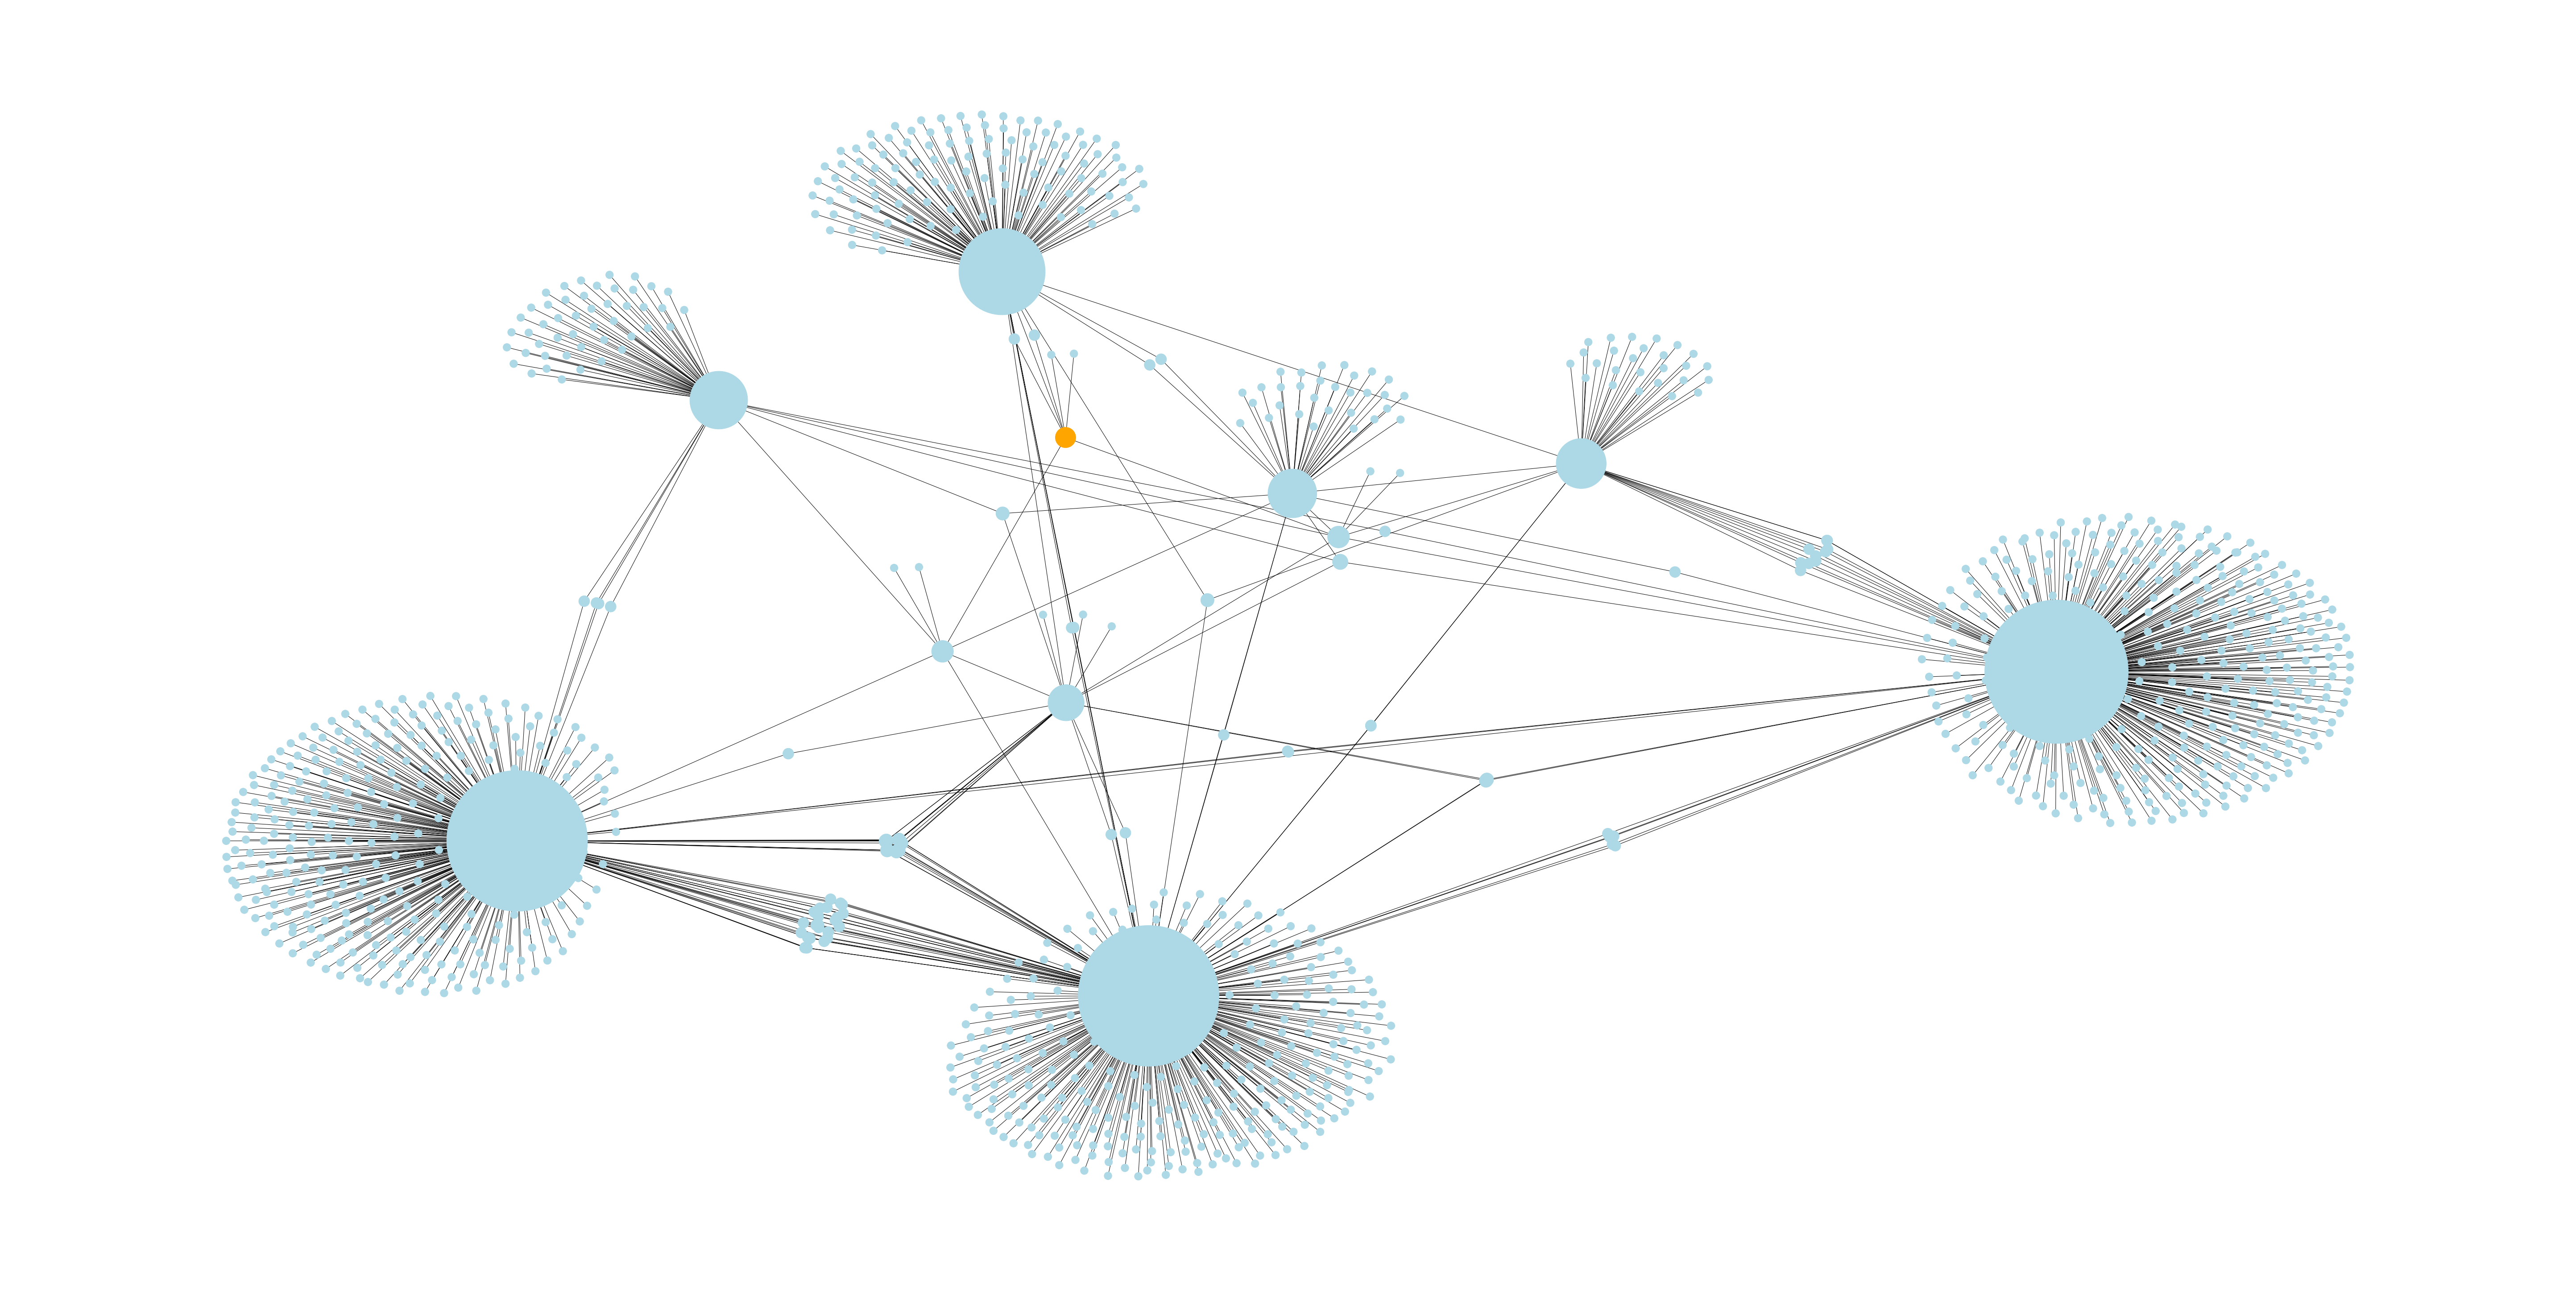

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(80,40))
nx.draw_spring(q171076_graph, with_labels=False, node_color=['orange' if node == NODE_URL else 'lightblue' for node in q171076_graph], node_size=[v * 300 for v in dict(q171076_graph.degree()).values()])

In [28]:
neighbor_degree_dict = sort_neighborhood_degree(sorted_nodes_by_degree, q171076_graph)

In [29]:
similarity_temp_graph_iceberg = initialize_similarity_matrix(permutations(sorted_nodes_by_degree), q171076_graph, neighbor_degree_dict)

28741  nodes were pruned by rule 1.
506016  nodes were pruned by rule 2.
33045  nodes were pruned by rule 3.


In [30]:
similarity_temp_graph_iceberg.has_node(NODE_URL)

True

In [31]:
aux, nodes = auxiliary(q171076_graph, similarity_temp_graph_iceberg)
#print(aux, nodes)

In [32]:
r_sim = rolesim(nx.Graph(aux), sorted(nodes), neighbor_degree_dict)

--------------------
Iteration  1
--------------------
Previous_iteration
[('http://www.wikidata.org/entity/Q1205336', 'http://www.wikidata.org/entity/Q13364705', {'weight': 0.6499999999999999}), ('http://www.wikidata.org/entity/Q1205336', 'http://www.wikidata.org/entity/Q21030206', {'weight': 0.58}), ('http://www.wikidata.org/entity/Q1205336', 'http://www.wikidata.org/entity/Q28096690', {'weight': 0.43999999999999995}), ('http://www.wikidata.org/entity/Q1205336', 'http://zbw.eu/stw/descriptor/14135-0', {'weight': 0.40499999999999997})]
Current_iteration
[('http://www.wikidata.org/entity/Q1205336', 'http://www.wikidata.org/entity/Q13364705', {'weight': 0.6091666666666666}), ('http://www.wikidata.org/entity/Q1205336', 'http://www.wikidata.org/entity/Q21030206', {'weight': 0.5706666666666667}), ('http://www.wikidata.org/entity/Q1205336', 'http://www.wikidata.org/entity/Q28096690', {'weight': 0.3}), ('http://www.wikidata.org/entity/Q1205336', 'http://zbw.eu/stw/descriptor/14135-0', {'weig

In [33]:
rolesim_df = nx.to_pandas_edgelist(r_sim)
rolesim_df = rolesim_df.drop(rolesim_df[(rolesim_df.weight <= BETA) | (rolesim_df.source != NODE_URL)].index)
rolesim_df.drop("source", axis=1, inplace=True)
rolesim_df.rename(columns = {'target':'node'}, inplace = True)
rolesim_df.sort_values(by=["weight"], ascending=False)

,node,weight
1192,http://www.wikidata.org/entity/Q21030206,0.547236
1238,https://d-nb.info/gnd/4019681-1,0.371069
1239,http://eurovoc.europa.eu/4743,0.371069
1260,http://g.co/kg/g/12dpwl333,0.371069
1261,http://commons.wikimedia.org/wiki/Special:File...,0.371069
1375,http://commons.wikimedia.org/wiki/Special:File...,0.366578
1376,http://g.co/kg/g/12271sg7,0.366578
1660,http://g.co/kg/m/04my4nt,0.366578
1661,http://www.wikidata.org/entity/Q28097660,0.366578


# Final Results

In [34]:
for index, row in rolesim_df.iterrows():
    df.loc[df.node == row['node'], 'rolesim'] = row['weight']

df['score'] = df.apply(lambda row: row.identifier if row.identifier == 1 else (0.5*row.rolesim + 0.5*row.neighborhood), axis=1)
df.sort_values(by=["score"], ascending=False)

,node,identifier,rolesim,neighborhood,score
376,http://www.wikidata.org/entity/Q178559,1,0.000000,0.285714,1.000000
463,http://www.wikidata.org/entity/Q21030206,0,0.547236,0.000000,0.273618
13,http://eurovoc.europa.eu/4743,0,0.371069,0.142857,0.256963
1192,https://d-nb.info/gnd/4019681-1,0,0.371069,0.142857,0.256963
595,http://www.wikidata.org/entity/Q28097660,0,0.366578,0.142857,0.254717
...,...,...,...,...,...
440,http://www.wikidata.org/entity/Q20198430,0,0.000000,0.000000,0.000000
441,http://www.wikidata.org/entity/Q20200091,0,0.000000,0.000000,0.000000
442,http://www.wikidata.org/entity/Q20277813,0,0.000000,0.000000,0.000000
443,http://www.wikidata.org/entity/Q2030755,0,0.000000,0.000000,0.000000


In [35]:
df.loc[df.score > 0].sort_values(by=["score"], ascending=False).to_html(Path().cwd() / "results" / NODE_HTML_FILE)